In [ ]:
! pip install wandb

     |████████████████████████████████| 2.0MB 7.1MB/s 
     |████████████████████████████████| 102kB 12.4MB/s 
     |████████████████████████████████| 163kB 34.3MB/s 
     |████████████████████████████████| 133kB 33.5MB/s 
     |████████████████████████████████| 71kB 10.9MB/s 
  Created wheel for pathtools: filename=pathtools-0.1.2-cp37-none-any.whl size=8786 sha256=504884149b1c12a1692454d5b68ae335de35da352808a5be4c000b2e27d7aa53
  Stored in directory: /root/.cache/pip/wheels/0b/04/79/c3b0c3a0266a3cb4376da31e5bfe8bba0c489246968a68e843
  Created wheel for subprocess32: filename=subprocess32-3.5.4-cp37-none-any.whl size=6489 sha256=4fed5d931c8f353ccf6fc8ebc81250e140271937643a71042b83ed72a3ad6896
  Stored in directory: /root/.cache/pip/wheels/68/39/1a/5e402bdfdf004af1786c8b853fd92f8c4a04f22aad179654d1
Successfully built pathtools subprocess32


**Question 1 (2 Marks)**
Download the fashion-MNIST dataset and plot 1 sample image for each class as shown in the grid below. Use "from keras.datasets import fashion_mnist" for getting the fashion mnist dataset.

In [ ]:
import wandb
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image as im
from keras.datasets import fashion_mnist

In [ ]:
(x_train,y_train),(x_test,y_test)=fashion_mnist.load_data()

4423680/4422102 [==============================] - 0s 0us/step


In [ ]:
showed=np.zeros(10)
i=0
images=[]
classes=[]
while (0 in showed):
  i=np.random.randint(0,len(y_train))
  if showed[y_train[i]]==0:
    images.append(im.fromarray(x_train[i]))
    classes.append(y_train[i])
    showed[y_train[i]]=1
  i=i+1

<IPython.core.display.Javascript object>

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


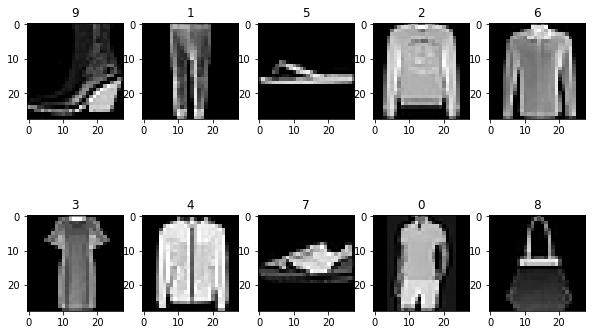

In [ ]:
wandb.init()
plt.figure(figsize=(10, 10))
for i, image in enumerate(images):
  img=plt.subplot(3, 5,i+1)
  img.set_title(classes[i])
  im = plt.imshow(image,cmap='gray')
  wandb.log({"img": [wandb.Image(im, caption="Cafe")]})

## FeedForward Neural Network

In [ ]:
samples=int(len(x_train)-0.1*len(x_train))
X_train=x_train[0:samples]
Y_train=y_train[0:samples]
X_val=x_train[samples:len(x_train)]
Y_val=y_train[samples:len(x_train)]
print(X_train.shape,X_val.shape)

(54000, 28, 28) (6000, 28, 28)


### Sweep functionality 

In [ ]:
# Configure the sweep – specify the parameters to search through, the search strategy, the optimization metric et all.
sweep_config = {
    'method': 'random', #grid, random
    'metric': {
      'name': 'accuracy',
      'goal': 'maximize'   
    },
    'parameters': {
        'epochs': {
            'values': [5, 10]
        },
        'no_of_hidden_layers': { 
            'values': [3, 4, 5]
            # 'values': [3]
        },
        'hidden_layer_size': {
            'values': [32, 64, 128]
            # 'values': [16]
        },
        'weight_decay':{
            'values': [0, 0.0005, 0.5]
        },
        'learning_rate': {
            'values': [1e-3, 1e-4]
            # 'values': [1e-3]
        },
        'optimizer': {
            'values': ['adam', 'nadam', 'sgd', 'rmsprop', 'momentum', 'nesterov']
            # 'values': ['gd']
        },
        'batch_size': {
            'values': [16,32,64]
            # 'values': [32]
        },       
        'weight_initialisation':{
            'values': ['random', 'Xavier']
        },
        'activation': {
            # 'values': ['relu', 'elu', 'selu', 'softmax']
            'values': ['sigmoid','tanh','ReLu']
        }
        
        
    }
}

### Initiate sweep function and get sweep id 

In [ ]:
sweep_id = wandb.sweep(sweep_config, entity="prachisahu47", project="Feed_Forward_Neural_Network_modules")

wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


Create sweep with ID: k9bepg6m
Sweep URL: https://wandb.ai/piyushac123/Feed_Forward_Neural_Network_modules/sweeps/k9bepg6m


In [ ]:
def init_w_and_b(config):
  # print('b')
  layers=config.no_of_hidden_layers+1
  neurons=[len(X_train[0].reshape(784))]
  for i in range(1,layers): neurons.append(config.hidden_layer_size)
  neurons.append(10)
  #print(neurons)
  w=[]
  b=[]
  if(config.weight_initialisation== 'random'):
    for i in range(1,layers+1):
      wx=np.random.rand(neurons[i],neurons[i-1])
      w.append(wx)
    for i in range(1,layers+1):
      bx=np.random.rand(neurons[i])
      b.append(bx)

  if(config.weight_initialisation== 'Xavier'):
    var=2/(neurons[0]+neurons[layers])
    mu=0
    for i in range(1,layers+1):
      wx=np.random.normal(mu,var,(neurons[i],neurons[i-1]))
      w.append(wx)
    for i in range(1,layers+1):
      bx=np.random.normal(mu,var,neurons[i])
      b.append(bx)
  
  return neurons, w, b

In [ ]:
def activation_func(a1, choice):
    if(choice == 'sigmoid'):
      return (1/(1+np.exp(-a1)))
    if(choice=='tanh'):
      return (2/(1+np.exp(-2*a1))-1)
    if(choice=='ReLu'):
      return np.multiply(1*(a1>=0),a1)

In [ ]:
def activation_func_derivative(a,choice):
  if(choice == 'sigmoid'):
      return activation_func(a,choice)*(1-activation_func(a,choice))
  if(choice=='tanh'):
    return 1-np.square(activation_func(a,choice))
  if(choice=='ReLu'):
    return 1*(a>=0)

In [ ]:
def get_val_accuracy(w,b,config):
  match=0
  for i in range(len(Y_val)):
    yhat=predict(w,b,X_val[i].reshape(784),config)
    if(np.argmax(yhat)==Y_val[i]):
      match+=1
  return match/len(Y_val)

In [ ]:
def get_accuracy(w,b,config):
  match=0
  for i in range(len(Y_train)):
    yhat=predict(w,b,X_train[i].reshape(784),config)
    if(np.argmax(yhat)==Y_train[i]):
      match+=1
  return match/len(Y_train)

In [ ]:
def val_cross_entropy(w,b,config):
  err=0
  for i in range(len(Y_val)):
    yhat=predict(w,b,X_val[i].reshape(784),config)
    err+=-np.log(yhat[Y_val[i]])
  l2norm=0
  for i in range(len(w)):
    l2norm+=np.linalg.norm(w[i])

  return err/len(Y_val)+l2norm*config.weight_decay/(2*len(Y_val))

In [ ]:
def cross_entropy(w,b,config):
  err=0
  for i in range(len(Y_train)):
    yhat=predict(w,b,X_train[i].reshape(784),config)
    err+=-np.log(yhat[Y_train[i]])
  l2norm=0
  for i in range(len(w)):
    l2norm+=np.linalg.norm(w[i])

  return err/len(Y_train)+l2norm*config.weight_decay/(2*len(Y_train))

In [ ]:
def predict(w,b,img,config):
  a=b[0]+np.dot(w[0],img)
  h=activation_func(a, config.activation) 

  layers=config.no_of_hidden_layers+1
  for i in range(1,layers-1):
    a=b[i]+np.dot(w[i],h)
    h=activation_func(a, config.activation)   
  lastLayer=b[layers-1]+np.dot(w[layers-1],h)
  y=softmax(lastLayer)
  return y

In [ ]:
def softmax(a):
  return np.exp(a)/sum(np.exp(a))

In [ ]:
def forward_prop(w,b,p,config):
  # print('c')
  layers = config.no_of_hidden_layers+1
  h=[]
  a=[]
  a1=b[0]+np.dot(w[0],X_train[p].reshape(784))
  a.append(a1)
  h1 = activation_func(a1, config.activation)
  h.append(h1)
  for i in range(1,layers-1):
    a1=b[i]+np.dot(w[i],h[i-1])
    a.append(a1)
    h1=activation_func(a1, config.activation) 
    h.append(h1)
  a1=b[layers-1]+np.dot(w[layers-1],h[layers-2])######Repeat
  a.append(a1)
  y=softmax(a1)
  return h,a,y

In [ ]:
def backward_prop(h,a,y,p,config,w,b):
  # print('e')
  layers = config.no_of_hidden_layers+1
  wdash=[]
  bdash=[]
  actualY=np.zeros(10)
  actualY[Y_train[p]]=1
  dela=y-actualY

  for i in range(0,layers-1):
    delw=np.outer(dela,h[layers-2-i])
    wdash.append(delw)
    bdash.append(dela)
    delh=np.dot(w[layers-1-i].T,dela)
    #g=(1/(1+np.exp(-a[layers-1-i-1])))   #chnge to actvatn derivative ???????????????????????
    gdash=activation_func_derivative(a[layers-1-i-1],config.activation)
    dela=np.multiply(delh,gdash)
  
  delw=np.outer(dela,X_train[p])
  wdash.append(delw)
  bdash.append(dela)
  wdash.reverse()
  bdash.reverse()
  return wdash,bdash


### Gradient Descent

In [ ]:
def gradient_descent(config):
  # print('a')
  # print(config.no_of_hidden_layers, config.hidden_layer_size, config.batch_size, config.learning_rate, config.activation)
  maxitr = config.epochs
  neurons, w, b = init_w_and_b(config)
  #s=len(X_train)
  error=[]
  val_error=[]
  accuracy=[]
  val_accuracy=[]
  for i in range(0,maxitr):
    wgrad=[]
    bgrad=[]
    bs=0
    for j in range(0,samples):
      bs+=1
      h,a,y=forward_prop(w,b,j,config)
      wdash,bdash=backward_prop(h,a,y,j,config,w,b)
      wgrad.append(wdash)
      bgrad.append(bdash)
      if bs%config.batch_size==0:
        w=np.subtract(w,config.learning_rate*np.sum(wgrad,axis=0))
        b=np.subtract(b,config.learning_rate*np.sum(bgrad,axis=0))
        wgrad.clear()
        bgrad.clear()
    error.append(cross_entropy(w,b,config))
    val_error.append(val_cross_entropy(w,b,config))
    accuracy.append(get_accuracy(w,b,config))
    val_accuracy.append(get_val_accuracy(w,b,config))

  return w,b,error,val_error,accuracy,val_accuracy

### Stochastic Gradient Descent

In [ ]:
def stocastic_gd(config):
  layers=config.no_of_hidden_layers+1
  epoch=config.epochs
  eta=config.learning_rate
  batch_size=config.batch_size

  neurons, w, b = init_w_and_b(config)

  #s=len(x_train)
  error=[]
  val_error=[]
  accuracy=[]
  val_accuracy=[]
  for i in range(0,epoch):
    wgrad=[]
    bgrad=[]
    bs=0
    for j in range(0,samples):
      bs+=1
      h,a,y=forward_prop(w,b,j,config)
      wdash,bdash=backward_prop(h,a,y,j,config,w,b)
      wgrad.append(wdash)
      bgrad.append(bdash)
      if bs%batch_size==0:
        w=np.subtract(w,eta*np.sum(wgrad,axis=0))
        b=np.subtract(b,eta*np.sum(bgrad,axis=0))
        wgrad.clear()
        bgrad.clear()
    error.append(cross_entropy(w,b,config))
    val_error.append(val_cross_entropy(w,b,config))
    accuracy.append(get_accuracy(w,b,config))
    val_accuracy.append(get_val_accuracy(w,b,config))
  return w,b,error,val_error,accuracy,val_accuracy
  # img_num=np.random.randint(0,len(y_test))
  # y_hat=predict(w,b,x_test[img_num])
  # print("probabilities of each class:",y_hat)

### Momentum Gradient Descent

In [ ]:
def momentum_gd(config):
  layers=config.no_of_hidden_layers+1
  epoch=config.epochs
  gamma=0.9
  eta=config.learning_rate
  batch_size=config.batch_size

  neurons, w, b = init_w_and_b(config)

  #s=len(x_train)
  
  pre_updt_w=[]
  for i in range(1,layers+1):
    pwx=np.zeros((neurons[i],neurons[i-1]))
    pre_updt_w.append(pwx)

  pre_updt_b=[]
  for i in range(1,layers+1):
    pbx=np.zeros(neurons[i])
    pre_updt_b.append(pbx)
  error=[]
  val_error=[]
  accuracy=[]
  val_accuracy=[]
  for i in range(0,epoch):
    wgrad=[]
    bgrad=[]
    bs=0
    for j in range(0,samples):
      bs+=1
      h,a,y=forward_prop(w,b,j,config)
      wdash,bdash=backward_prop(h,a,y,j,config,w,b)
      wgrad.append(wdash)
      bgrad.append(bdash)
      if bs%batch_size==0:
        updt_w = np.add((gamma*np.array(pre_updt_w)), (eta*np.sum(wgrad,axis=0)))
        updt_b = np.add((gamma*np.array(pre_updt_b)), (eta*np.sum(bgrad,axis=0)))
        w=np.subtract(w,updt_w)
        b=np.subtract(b,updt_b)
        pre_updt_w = updt_w
        pre_updt_b = updt_b
        wgrad.clear()
        bgrad.clear()
    error.append(cross_entropy(w,b,config))
    val_error.append(val_cross_entropy(w,b,config))
    accuracy.append(get_accuracy(w,b,config))
    val_accuracy.append(get_val_accuracy(w,b,config))
  return w,b,error,val_error,accuracy,val_accuracy

### Nesterov Accelerated Gradient Descent

In [ ]:
def Nesterov_gd(config):
  layers=config.no_of_hidden_layers+1
  epoch=config.epochs
  gamma=0.9
  eta=config.learning_rate
  batch_size=config.batch_size

  neurons, w, b = init_w_and_b(config)

  updt_w=[]
  for i in range(1,layers+1):
    pwx=np.zeros((neurons[i],neurons[i-1]))
    updt_w.append(pwx)
  
  updt_b=[]
  for i in range(1,layers+1):
    pbx=np.zeros(neurons[i])
    updt_b.append(pbx)
  
  error=[]
  val_error=[]
  accuracy=[]
  val_accuracy=[]
  for i in range(0,epoch):
    wgrad=[]
    bgrad=[]
    w_la=np.subtract(w,gamma*np.array(updt_w))
    b_la=np.subtract(b,gamma*np.array(updt_b))
    bs=0
    for j in range(0,samples):
      bs+=1
      h,a,y=forward_prop(w_la,b_la,j,config)
      wdash,bdash=backward_prop(h,a,y,j,config,w_la,b_la)
      wgrad.append(wdash)
      bgrad.append(bdash)
      if bs%batch_size==0:
        updt_w = np.add((gamma*np.array(updt_w)), (eta*np.sum(wgrad,axis=0)))
        updt_b = np.add((gamma*np.array(updt_b)), (eta*np.sum(bgrad,axis=0)))

        w=np.subtract(w,updt_w)
        b=np.subtract(b,updt_b)

        w_la=np.subtract(w,gamma*np.array(updt_w))
        b_la=np.subtract(b,gamma*np.array(updt_b))

        wgrad.clear()
        bgrad.clear()
    error.append(cross_entropy(w,b,config))
    val_error.append(val_cross_entropy(w,b,config))
    accuracy.append(get_accuracy(w,b,config))
    val_accuracy.append(get_val_accuracy(w,b,config))
  return w,b,error,val_error,accuracy,val_accuracy

### RMSProp Gradient Descent



In [ ]:
def RMS_prop(config):
  layers=config.no_of_hidden_layers+1
  epoch_size=config.epochs
  eta=config.learning_rate
  epsilon=0.00000001
  beta=0.9
  #s=len(x_train)-6000
  batch_size=config.batch_size

  neurons, w, b = init_w_and_b(config)

  vb=[]
  for i in range(1,layers+1):
    bx=np.zeros(neurons[i])
    vb.append(bx)

  vw=[]
  for i in range(1,layers+1):
    wx=np.zeros((neurons[i],neurons[i-1]))
    vw.append(wx)
  error=[]
  val_error=[]
  accuracy=[]
  val_accuracy=[]
  for i in range(epoch_size):
    wgrad=[]
    bgrad=[]
    bs=0
    for j in range(0,samples):
      bs+=1
      h,a,y=forward_prop(w,b,j,config)
      wdash,bdash=backward_prop(h,a,y,j,config,w,b)
      wgrad.append(wdash)
      bgrad.append(bdash)
      if bs%batch_size==0:
        vw=np.add(beta*np.array(vw),(1-beta)*np.square(np.sum(wgrad,axis=0)))
        vb=np.add(beta*np.array(vb),(1-beta)*np.square(np.sum(bgrad,axis=0)))
        w = np.subtract(w, np.multiply(np.divide(eta, np.add(vw,epsilon)), np.sum(wgrad,axis=0)))
        b = np.subtract(b, np.multiply(np.divide(eta, np.add(vb,epsilon)), np.sum(bgrad,axis=0)))
        wgrad.clear()
        bgrad.clear()
    error.append(cross_entropy(w,b,config))
    val_error.append(val_cross_entropy(w,b,config))
    accuracy.append(get_accuracy(w,b,config))
    val_accuracy.append(get_val_accuracy(w,b,config))
  return w,b,error,val_error,accuracy,val_accuracy

### Adam Gradient Descent

In [ ]:
def Adam(config):
  layers=config.no_of_hidden_layers+1
  epoch=config.epochs
  eta=config.learning_rate
  beta1=0.9
  beta2=0.999
  epsilon=0.00000001
  batch_size=config.batch_size
  #s=len(x_train)-6000
  
  neurons, w, b = init_w_and_b(config)

  mw=[]
  vw=[]
  for i in range(1,layers+1):
    wx=np.zeros((neurons[i],neurons[i-1]))
    mw.append(wx)
    vw.append(wx)
  
  mb=[]
  vb=[]
  error=[]
  val_error=[]
  accuracy=[]
  val_accuracy=[]
  for i in range(1,layers+1):
    bx=np.zeros(neurons[i])
    mb.append(bx)
    vb.append(bx)


  for i in range(0,epoch):
    wgrad=[]
    bgrad=[]
    bs=0
    for j in range(0,samples):
      bs+=1
      h,a,y=forward_prop(w,b,j,config)
      wdash,bdash=backward_prop(h,a,y,j,config,w,b)
      wgrad.append(wdash)
      bgrad.append(bdash)
      if bs%batch_size==0:
        mw = np.add(beta1*np.array(mw), (1-beta1)*np.sum(wgrad,axis=0))
        mb = np.add(beta1*np.array(mb), (1-beta1)*np.sum(bgrad,axis=0))

        vw = np.add(beta2*np.array(vw), (1-beta2)*np.square(np.sum(wgrad,axis=0)))
        vb = np.add(beta2*np.array(vb), (1-beta2)*np.square(np.sum(bgrad,axis=0)))

        m_w_hat = np.divide(mw, (1-(beta1**(bs/batch_size))))
        m_b_hat = np.divide(mb, (1-(beta1**(bs/batch_size))))

        v_w_hat = np.divide(vw, (1-(beta2**(bs/batch_size))))
        v_b_hat = np.divide(vb, (1-(beta2**(bs/batch_size))))

        w = np.subtract(w, np.multiply(np.divide(eta, np.add(v_w_hat,epsilon)), m_w_hat))
        b = np.subtract(b, np.multiply(np.divide(eta, np.add(v_b_hat,epsilon)), m_b_hat))

        wgrad.clear()
        bgrad.clear()
    error.append(cross_entropy(w,b,config))
    val_error.append(val_cross_entropy(w,b,config))
    accuracy.append(get_accuracy(w,b,config))
    val_accuracy.append(get_val_accuracy(w,b,config))
  return w,b,error,val_error,accuracy,val_accuracy

### Nadam Gradient Descent

In [ ]:
def NADAM(config):

  layers=config.no_of_hidden_layers+1
  epoch=config.epochs
  eta=config.learning_rate
  beta1=0.9
  beta2=0.999
  epsilon=0.00000001
  batch_size=config.batch_size
  #s=len(x_train)-6000
  
  neurons, w, b = init_w_and_b(config)

  mw=[]
  vw=[]
  for i in range(1,layers+1):
    wx=np.zeros((neurons[i],neurons[i-1]))
    mw.append(wx)
    vw.append(wx)

  mb=[]
  vb=[]
  for i in range(1,layers+1):
    bx=np.zeros(neurons[i])
    mb.append(bx)
    vb.append(bx)
  
  error=[]
  val_error=[]
  accuracy=[]
  val_accuracy=[]
  for i in range(0,epoch):
    wgrad=[]
    bgrad=[]
    w_la=np.subtract(w,beta1*np.array(mw))
    b_la=np.subtract(b,beta1*np.array(mb))
    bs=0
    for j in range(0,samples):
      bs+=1
      h,a,y=forward_prop(w_la,b_la,j,config)
      wdash,bdash=backward_prop(h,a,y,j,config,w_la,b_la)
      wgrad.append(wdash)
      bgrad.append(bdash)
      if bs%batch_size==0:
        mw = np.add((beta1*np.array(mw)), ((1-beta1)*np.sum(wgrad,axis=0)))
        mb = np.add((beta1*np.array(mb)), ((1-beta1)*np.sum(bgrad,axis=0)))

        vw = np.add(beta2*np.array(vw), (1-beta2)*np.square(np.sum(wgrad,axis=0)))
        vb = np.add(beta2*np.array(vb), (1-beta2)*np.square(np.sum(bgrad,axis=0)))

        m_w_hat = np.divide(mw, (1-(beta1**(bs/batch_size))))
        m_b_hat = np.divide(mb, (1-(beta1**(bs/batch_size))))

        v_w_hat = np.divide(vw, (1-(beta2**(bs/batch_size))))
        v_b_hat = np.divide(vb, (1-(beta2**(bs/batch_size))))

        w = np.subtract(w, np.multiply(np.divide(eta, np.add(v_w_hat,epsilon)), m_w_hat))
        b = np.subtract(b, np.multiply(np.divide(eta, np.add(v_b_hat,epsilon)), m_b_hat))

        w_la=np.subtract(w,beta1*np.array(mw))
        b_la=np.subtract(b,beta1*np.array(mb))

        wgrad.clear()
        bgrad.clear()
    error.append(cross_entropy(w,b,config))
    val_error.append(val_cross_entropy(w,b,config))
    accuracy.append(get_accuracy(w,b,config))
    val_accuracy.append(get_val_accuracy(w,b,config))
  return w,b,error,val_error,accuracy,val_accuracy 

In [ ]:
# The sweep calls this function with each set of hyperparameters
def train():
  # Default values for hyper-parameters we're going to sweep over
    config_defaults = {
        'epochs': 5,
        'batch_size': 128,
        'no_of_hidden_layers': 3,
        # 'weight_decay': 0.0005,
        'hidden_layer_size' : 32,
        'learning_rate': 1e-3,
        'activation': 'sigmoid',
        'optimizer': 'sgd',
        'weight_initialisation':'random',
        'weight_decay':0,
        'gamma':0.9
    }
    # Initialize a new wandb run
    wandb.init(config=config_defaults)
    
    # Config is a variable that holds and saves hyperparameters and inputs
    # config = wandb.config
    if wandb.config.optimizer == 'gd':
      w,b,error,val_error,accuracy,val_accuracy = gradient_descent(wandb.config)
      
    elif wandb.config.optimizer == 'sgd':
      w,b,error,val_error,accuracy,val_accuracy = stocastic_gd(wandb.config)
     
    elif wandb.config.optimizer == 'momentum':
      w,b,error,val_error,accuracy,val_accuracy = momentum_gd(wandb.config)
      
    elif wandb.config.optimizer == 'nesterov':
      w,b,error,val_error,accuracy,val_accuracy = Nesterov_gd(wandb.config)

    elif wandb.config.optimizer == 'rmsprop':
      w,b,error,val_error,accuracy,val_accuracy = RMS_prop(wandb.config)
     
    elif wandb.config.optimizer == 'nadam':
      w,b,error,val_error,accuracy,val_accuracy = NADAM(wandb.config)
      
    elif wandb.config.optimizer == 'adam':
      w,b,error,val_error,accuracy,val_accuracy = Adam(wandb.config)

    print("error :",error)
    print("val_error :",val_error)
    print("accuracy :",accuracy)
    print("val_accuracy :",val_accuracy)
    
    for i in range(wandb.config.epochs):
      wandb.log({'val_loss' : val_error[i], 'val_accuracy': val_accuracy[i],'loss' : error[i], 'accuracy': accuracy[i], 'epoch': i})
    
    # y_val_predict = []
    # for i in range(len(Y_val)):
    #   y_val_predict.append(predict(w,b,X_val[i].reshape(784),wandb.config))
    # # print(y_val_predict)
    # y_val_probs = [0 for _ in range(0,10)]
    # for i in range(len(Y_val)):
    #   y_val_probs[y_val_predict[i]] +=1
    # np.divide(y_val_probs,len(Y_val))
    # # print(y_val_probs) 

    # wandb.log({"conf_mat" : wandb.sklearn.plot_confusion_matrix(Y_val, y_val_probs, labels)})

    
    #error=cross_entropy(w,b,wandb.config)
    #wandb.log()
    # print(w)
    # print(b)
    # wandb.finish()

In [ ]:
wandb.agent(sweep_id, train)

wandb: WARNING Calling wandb.login() after wandb.init() has no effect.
wandb: Agent Starting Run: 5ny42xaa with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	hidden_layer_size: 128
wandb: 	learning_rate: 0.001
wandb: 	no_of_hidden_layers: 5
wandb: 	optimizer: adam
wandb: 	weight_decay: 0
wandb: 	weight_initialisation: random


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:43: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:87: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:44: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you m

error : [6.950592553974823, 2.316731745276841, 2.3168577565581123, 2.316862727604938, 2.3168628673449625]
val_error : [7.090001452645033, 2.3152604494070466, 2.3153113790502315, 2.31531337293079, 2.315313422480011]
accuracy : [0.09996296296296296, 0.09996296296296296, 0.09996296296296296, 0.09996296296296296, 0.09996296296296296]
val_accuracy : [0.10033333333333333, 0.10033333333333333, 0.10033333333333333, 0.10033333333333333, 0.10033333333333333]


val_loss,2.31531
val_accuracy,0.10033
loss,2.31686
accuracy,0.09996
epoch,4
_runtime,638
_timestamp,1615707676
_step,4


val_loss,█▁▁▁▁
val_accuracy,▁▁▁▁▁
loss,█▁▁▁▁
accuracy,▁▁▁▁▁
epoch,▁▃▅▆█
_runtime,▁▁▁▁▁
_timestamp,▁▁▁▁▁
_step,▁▃▅▆█


wandb: Agent Starting Run: a927idx6 with config:
wandb: 	activation: ReLu
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	hidden_layer_size: 128
wandb: 	learning_rate: 0.0001
wandb: 	no_of_hidden_layers: 5
wandb: 	optimizer: momentum
wandb: 	weight_decay: 0.0005
wandb: 	weight_initialisation: random
wandb: Currently logged in as: piyushac123 (use `wandb login --relogin` to force relogin)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: overflow encountered in exp
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in true_divide
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:36: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:37: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:38: VisibleDeprecationWarning: Creating an n